**General Description**

The following notebook contains the code to fine-tune, validate, and test a rainfall-runoff model using an LSTM network architecture. The notebook support running experiments in different large-sample hydrology datasets including: CAMELS-GB, CAMELS-US, CAMELS-DE. The details for each dataset can be read from a .yml file.

Fine-tuning process includes (1) loading a model pre-trained on a diverse dataset, (2) fine-tuning this pre-trained model on the target basins with a small learning rate.

***Authors:***
- Tianlong Jia (tianlong.jia@kit.edu)


In [1]:
# Import necessary packages
import datetime
import pickle
import random
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

sys.path.append("..")
# Import classes and functions from other files
from hy2dl.datasetzoo import get_dataset
from hy2dl.evaluation.metrics import nse
from hy2dl.modelzoo import get_model
from hy2dl.training.loss import nse_basin_averaged
from hy2dl.utils.config import Config
from hy2dl.utils.optimizer import Optimizer
from hy2dl.utils.utils import set_random_seed, upload_to_device

# colorblind friendly palette
color_palette = {"observed": "#377eb8", "simulated": "#4daf4a"}

## 1. Load model config

It loads a pre-trained model's config as the base config, then it updates the config for fine-tuning, including: pre_trained_path, finetune_modules, etc.

In [ ]:
# load finetune config and check for a non-empty list of finetune_modules
fine_tune_config_file = "../examples/finetune_camels_de.yml"

temp_config = Config(fine_tune_config_file)
if not temp_config.finetune_modules:
    raise ValueError("For finetuning, at least one model part has to be specified by 'finetune_modules'.")

# load base run config and combine with the fine-tune arguments
config = Config(temp_config.pre_trained_path / "config.yml")
config.update_config(fine_tune_config_file)
config.init_experiment()
config.dump()

Folder '..\results\finetune_camels_de_seed_110' was created to store the results.


## 2. Load pre-trained model weights

In [3]:
# Initialize model
set_random_seed(cfg=config)
model = get_model(config).to(config.device)

# Load pre-trained model from a checkpoint file
checkpoint_path = config.pre_trained_path/ "model" / "model_epoch_1"  # To do 
# checkpoint_path = "../results/LSTM_CAMELS_DE_seed_110/model/model_epoch_3"
state = torch.load(checkpoint_path, map_location=config.device)
model.load_state_dict(state)
config.logger.info(f"Load pre-trained model from checkpoint {checkpoint_path}")

# config.logger.info(f"Model layers: {state.keys()}")
# config.logger.info(f"Model architecture: {model}")

2025-12-17 21:39:05 - Load pre-trained model from checkpoint ..\results\LSTM_CAMELS_DE_seed_110\model\model_epoch_1


## 3. Create datasets and dataloaders used to train/validate the model

In [4]:
# Get dataset class
Dataset = get_dataset(config)

# Dataset training
config.logger.info(f"Loading training data from {config.dataset} dataset")
total_time = time.time()

training_dataset = Dataset(cfg=config, time_period="training")

# perform standardization on fine-tuning data using the values from pre-training process
if config.load_pretrained_scaler:
    scaler_path = config.pre_trained_path / "scaler.pickle"
    with open(scaler_path, "rb") as f:
        pretrained_scaler = pickle.load(f)
    config.logger.info(f"Standardize fine-tuning data using scaler obtaied from pre-training process: {scaler_path}")
    training_dataset.calculate_basin_std()
    training_dataset.scaler = pretrained_scaler
    training_dataset.standardize_data()
# perform standardization on fine-tuning data using values calculated from this data
else:
    config.logger.info(f"Standardize fine-tuning data without scaler obtaied from pre-training process")
    training_dataset.calculate_basin_std()
    training_dataset.calculate_global_statistics(save_scaler=True)
    training_dataset.standardize_data()

config.logger.info(f"Number of entities with valid samples: {len(training_dataset.df_ts)}")
config.logger.info(
    f"Time required to process {len(training_dataset.df_ts)} entities: "
    f"{datetime.timedelta(seconds=int(time.time() - total_time))}"
)
config.logger.info(f"Number of valid training samples: {len(training_dataset)}\n")

# Dataloader training
train_loader = DataLoader(
    dataset=training_dataset,
    batch_size=config.batch_size_training,
    shuffle=True,
    drop_last=True,
    collate_fn=training_dataset.collate_fn,
    num_workers=config.num_workers,
)

# Print details of a loader´s sample to check that the format is correct
config.logger.info("Details training dataloader".center(60, "-"))
config.logger.info(f"Batch structure (number of batches: {len(train_loader)})")
config.logger.info(f"{'Key':^30}|{'Shape':^30}")
# config.logger.info("-" * 60)
# Loop through the sample dictionary and print the shape of each element
for key, value in next(iter(train_loader)).items():
    if key.startswith(("x_d", "x_conceptual")):
        config.logger.info(f"{key}")
        for i, v in value.items():
            config.logger.info(f"{i:^30}|{str(v.shape):^30}")
    else:
        config.logger.info(f"{key:<30}|{str(value.shape):^30}")
config.logger.info("")  # prints a blank line

2025-12-17 21:39:05 - Loading training data from camels_de dataset


Processing entities: 100%|##########| 2/2 [00:00<00:00, 21.15entity/s]

2025-12-17 21:39:05 - Standardize fine-tuning data using scaler obtaied from pre-training process: ..\results\LSTM_CAMELS_DE_seed_110\scaler.pickle
2025-12-17 21:39:05 - Number of entities with valid samples: 2
2025-12-17 21:39:05 - Time required to process 2 entities: 0:00:00
2025-12-17 21:39:05 - Number of valid training samples: 883

2025-12-17 21:39:05 - ----------------Details training dataloader-----------------
2025-12-17 21:39:05 - Batch structure (number of batches: 3)
2025-12-17 21:39:05 -              Key              |            Shape             


2025-12-17 21:39:14 - x_d
2025-12-17 21:39:14 -       precipitation_mean      |    torch.Size([256, 365])    
2025-12-17 21:39:14 -      precipitation_stdev      |    torch.Size([256, 365])    
2025-12-17 21:39:14 -     radiation_global_mean     |    torch.Size([256, 365])    
2025-12-17 21:39:14 -        temperature_min        |    torch.Size([256, 365])    
2025-12-17 21:39:14 -        temperature_max        |    torch.Size([256, 365])    
2025-12-17 21:39:14 - x_s                           |    torch.Size([256, 17])     
2025-12-17 21:39:14 - y_obs                         |   torch.Size([256, 1, 1])    
2025-12-17 21:39:14 - std_basin                     |   torch.Size([256, 1, 1])    
2025-12-17 21:39:14 - basin                         |            (256,)            
2025-12-17 21:39:14 - date                          |           (256, 1)           
2025-12-17 21:39:14 - 


In [5]:
# In evaluation (validation and testing) we will create an individual dataset per basin
config.logger.info(f"Loading validation data from {config.dataset} dataset")
entities_ids = np.loadtxt(config.path_entities_validation, dtype="str").tolist()
iterator = tqdm(
    [entities_ids] if isinstance(entities_ids, str) else entities_ids,
    desc="Processing entities",
    unit="entity",
    ascii=True,
)

total_time = time.time()
validation_dataset = {}
for entity in iterator:
    dataset = Dataset(cfg=config, time_period="validation", check_NaN=False, entities_ids=entity)
    dataset.scaler = training_dataset.scaler
    dataset.standardize_data(standardize_output=False)
    validation_dataset[entity] = dataset

config.logger.info(
    f"Time required to process {len(iterator)} entities: {datetime.timedelta(seconds=int(time.time() - total_time))}\n"
)

2025-12-17 21:39:14 - Loading validation data from camels_de dataset


Processing entities: 100%|##########| 2/2 [00:00<00:00, 12.56entity/s]

2025-12-17 21:39:14 - Time required to process 2 entities: 0:00:00



## 4. Freeze model's modules

In [6]:
# freeze all model weights
for param in model.parameters():
    param.requires_grad = False

unresolved_modules = []

# unfreeze parameters specified in config as tuneable parameters
if isinstance(config.finetune_modules, list):
    for module_part in config.finetune_modules:
        if module_part in model.module_parts:
            module = getattr(model, module_part)
            config.logger.info(f"Trainable modules: {module}")
            for param in module.parameters():
                param.requires_grad = True
        else:
            unresolved_modules.append(module_part)
else:
    # if it was no list, it has to be a dictionary
    for module_group, module_parts in config.finetune_modules.items():
        if module_group in model.module_parts:
            if isinstance(module_parts, str):
                module_parts = [module_parts]
            for module_part in module_parts:
                module = getattr(model, module_group)[module_part]
                config.logger.info(f"Trainable modules: {module}")
                for param in module.parameters():
                    param.requires_grad = True
            else:
                unresolved_modules.append(module_group)
if unresolved_modules:
    config.logger.warning(f"Could not resolve the following module parts for finetuning: {unresolved_modules}")

2025-12-17 21:39:14 - Trainable modules: LSTM(22, 128, batch_first=True)
2025-12-17 21:39:14 - Trainable modules: Linear(in_features=128, out_features=1, bias=True)


## 5. Fine-tune model

In [7]:
# Initialize optimizer
optimizer = Optimizer(cfg=config, model=model)

# Training report structure
config.logger.info("Training model".center(60, "-"))
config.logger.info(f"{'':^16}|{'Trainining':^21}|{'Validation':^21}|")
config.logger.info(f"{'Epoch':^5}|{'LR':^10}|{'Loss':^10}|{'Time':^10}|{'Metric':^10}|{'Time':^10}|")

total_time = time.time()
# Loop through epochs
for epoch in range(1, config.epochs + 1):
    train_time = time.time()
    loss_evol = []
    # Training -------------------------------------------------------------------------------------------------------
    model.train()
    # Loop through the different batches in the training dataset
    iterator = tqdm(
        train_loader, desc=f"Epoch {epoch}/{config.epochs}. Training", unit="batches", ascii=True, leave=False
    )

    for idx, sample in enumerate(iterator):
        # reach maximum iterations per epoch
        if config.max_updates_per_epoch is not None and idx >= config.max_updates_per_epoch:
            break

        sample = upload_to_device(sample, config.device)  # upload tensors to device
        optimizer.optimizer.zero_grad()  # sets gradients to zero

        # Forward pass of the model
        pred = model(sample)
        # Calcuate loss
        loss = nse_basin_averaged(y_sim=pred["y_hat"], y_obs=sample["y_obs"], per_basin_target_std=sample["std_basin"])
        # print("per_basin_target_std:", sample["std_basin"])
        # Backpropagation (calculate gradients)
        loss.backward()

        # Update model parameters (e.g, weights and biases)
        optimizer.clip_grad_and_step(epoch, idx)

        # Keep track of the loss per batch
        loss_evol.append(loss.item())
        iterator.set_postfix({"loss": f"{np.mean(loss_evol):.3f}"})

        # remove elements from cuda to free memory
        del sample, pred
        torch.cuda.empty_cache()

    # training report
    lr = optimizer.optimizer.param_groups[0]["lr"]
    mean_loss = np.mean(loss_evol)
    train_duration = str(datetime.timedelta(seconds=int(time.time() - train_time)))
    report = f"{epoch:^5}|{lr:^10.5f}|{mean_loss:^10.3f}|{train_duration:^10}|"

    # Validation -----------------------------------------------------------------------------------------------------
    if epoch % config.validate_every == 0:
        val_time = time.time()
        model.eval()
        validation_results = {}
        with torch.no_grad():
            # If we define validate_n_random_basins as 0 or negative, we take all the basins. Otherwise, we randomly
            # select the number of basins defined in validate_n_random_basins
            if config.validate_n_random_basins <= 0:
                validation_basin_ids = validation_dataset.keys()
            else:
                validation_basin_ids = random.sample(list(validation_dataset.keys()), config.validate_n_random_basins)

            # Go through each basin
            iterator = tqdm(
                validation_basin_ids,
                desc=f"Epoch {epoch}/{config.epochs}. Validation",
                unit="basins",
                ascii=True,
                leave=False,
            )

            for basin in iterator:
                loader = DataLoader(
                    dataset=validation_dataset[basin],
                    batch_size=config.batch_size_evaluation,
                    shuffle=False,
                    drop_last=False,
                    collate_fn=validation_dataset[basin].collate_fn,
                    num_workers=config.num_workers,
                )

                df_ts = pd.DataFrame()
                for sample in loader:
                    sample = upload_to_device(sample, config.device)
                    # Forward pass of the model
                    pred = model(sample)
                    # Backtransform information (unstandardize the output)
                    y_std = validation_dataset[basin].scaler["y_std"].to(config.device)
                    y_mean = validation_dataset[basin].scaler["y_mean"].to(config.device)
                    y_sim = pred["y_hat"] * y_std + y_mean

                    # join results in a dataframe (easier to evaluate/plot later)
                    df = pd.DataFrame(
                        {"y_obs": sample["y_obs"].flatten().cpu().detach(), "y_sim": y_sim.flatten().cpu().detach()},
                        index=pd.to_datetime(sample["date"].flatten()),
                    )
                    # print("sample[y_obs]: ", sample["y_obs"])
                    # print("sample[y_sim]: ", y_sim)
                    df_ts = pd.concat([df_ts, df], axis=0)

                    # remove elements from cuda to free memory
                    del sample, pred, y_sim
                    torch.cuda.empty_cache()

                validation_results[basin] = df_ts

            # average loss validation
            loss_validation = nse(df_results=validation_results)
            report += f"{loss_validation:^10.3f}|{str(datetime.timedelta(seconds=int(time.time() - val_time))):^10}|"

    # No validation
    else:
        report += f"{'':^10}|{'':^10}|"

    # Print report and save model
    config.logger.info(report)
    torch.save(model.state_dict(), config.path_save_folder / "model" / f"model_epoch_{epoch}")
    # modify learning rate
    optimizer.update_optimizer_lr(epoch=epoch)

# print total training time
config.logger.info(f"Total training time: {datetime.timedelta(seconds=int(time.time() - total_time))}\n")

2025-12-17 21:39:15 - -----------------------Training model-----------------------
2025-12-17 21:39:15 -                 |     Trainining      |     Validation      |
2025-12-17 21:39:15 - Epoch|    LR    |   Loss   |   Time   |  Metric  |   Time   |


2025-12-17 21:39:32 -   1  | 0.00100  |  0.376   | 0:00:09  |  -0.221  | 0:00:06  |


2025-12-17 21:39:49 -   2  | 0.00100  |  0.330   | 0:00:10  |  -0.148  | 0:00:06  |


2025-12-17 21:40:06 -   3  | 0.00100  |  0.279   | 0:00:10  |  -0.154  | 0:00:07  |


2025-12-17 21:40:23 -   4  | 0.00010  |  0.276   | 0:00:09  |  -0.153  | 0:00:07  |


2025-12-17 21:40:43 -   5  | 0.00010  |  0.232   | 0:00:10  |  -0.151  | 0:00:09  |
2025-12-17 21:40:43 - Total training time: 0:01:27



## 6. Test model

In [8]:
# In evaluation (validation and testing) we will create an individual dataset per basin
config.logger.info(f"Loading testing data from {config.dataset} dataset")

entities_ids = np.loadtxt(config.path_entities_testing, dtype="str").tolist()
iterator = tqdm(
    [entities_ids] if isinstance(entities_ids, str) else entities_ids,
    desc="Processing entities",
    unit="entity",
    ascii=True,
)

total_time = time.time()
testing_dataset = {}
for entity in iterator:
    dataset = Dataset(cfg=config, time_period="testing", check_NaN=False, entities_ids=entity)
    # Load the training scaler
    dataset.scaler = training_dataset.scaler
    dataset.standardize_data(standardize_output=False)
    testing_dataset[entity] = dataset

config.logger.info(
    f"Time required to process {len(iterator)} entities: {datetime.timedelta(seconds=int(time.time() - total_time))}\n"
)

2025-12-17 21:40:43 - Loading testing data from camels_de dataset


Processing entities: 100%|##########| 2/2 [00:00<00:00,  8.24entity/s]

2025-12-17 21:40:43 - Time required to process 2 entities: 0:00:00



In [9]:
config.logger.info("Testing model".center(60, "-"))
total_time = time.time()

model.eval()
test_results = {}
with torch.no_grad():
    # Go through each basin
    iterator = tqdm(testing_dataset, desc="Testing", unit="basins", ascii=True)
    for basin in iterator:
        loader = DataLoader(
            dataset=testing_dataset[basin],
            batch_size=config.batch_size_evaluation,
            shuffle=False,
            drop_last=False,
            collate_fn=testing_dataset[basin].collate_fn,
            num_workers=config.num_workers,
        )

        df_ts = pd.DataFrame()
        for sample in loader:
            sample = upload_to_device(sample, config.device)  # upload tensors to device
            pred = model(sample)
            # backtransformed information
            y_sim = pred["y_hat"] * testing_dataset[basin].scaler["y_std"].to(config.device) + (
                testing_dataset[basin].scaler["y_mean"].to(config.device)
            )

            # join results in a dataframe and store them in a dictionary (is easier to plot later)
            df = pd.DataFrame(
                {"y_obs": sample["y_obs"].flatten().cpu().detach(), "y_sim": y_sim.flatten().cpu().detach()},
                index=pd.to_datetime(sample["date"].flatten()),
            )

            df_ts = pd.concat([df_ts, df], axis=0)

            # remove from cuda
            del sample, pred, y_sim
            torch.cuda.empty_cache()

        test_results[basin] = df_ts

# Save results as a pickle file
with open(config.path_save_folder / "test_results.pickle", "wb") as f:
    pickle.dump(test_results, f)

config.logger.info(f"Total testing time: {datetime.timedelta(seconds=int(time.time() - total_time))}")

2025-12-17 21:40:43 - -----------------------Testing model------------------------


Testing: 100%|##########| 2/2 [00:20<00:00, 10.03s/basins]

2025-12-17 21:41:03 - Total testing time: 0:00:20


## 7. Initial analysis

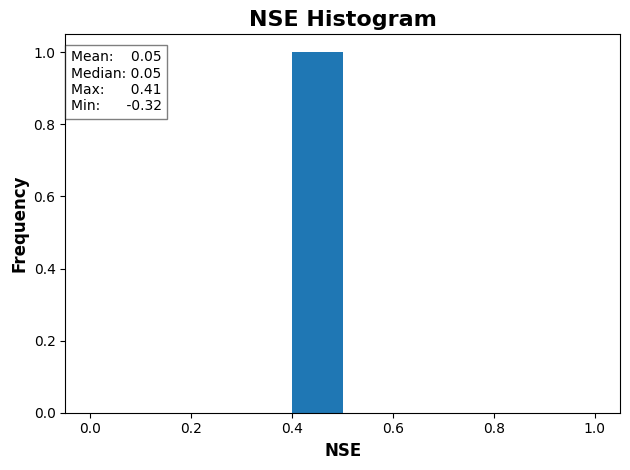

In [10]:
# Loss testing
loss_testing = nse(df_results=test_results, average=False)
df_NSE = pd.DataFrame(data={"basin_id": testing_dataset.keys(), "NSE": np.round(loss_testing, 3)})
df_NSE = df_NSE.set_index("basin_id")
df_NSE.to_csv(config.path_save_folder / "NSE_testing.csv", index=True, header=True)

# Plot the histogram
plt.hist(df_NSE["NSE"], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Add NSE statistics to the plot
plt.text(
    0.01,
    0.8,
    (
        f"Mean: {'%.2f' % df_NSE['NSE'].mean():>7}\n"
        f"Median: {'%.2f' % df_NSE['NSE'].median():>0}\n"
        f"Max: {'%.2f' % df_NSE['NSE'].max():>9}\n"
        f"Min: {'%.2f' % df_NSE['NSE'].min():>10}"
    ),
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
)

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel("NSE", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.title("NSE Histogram", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

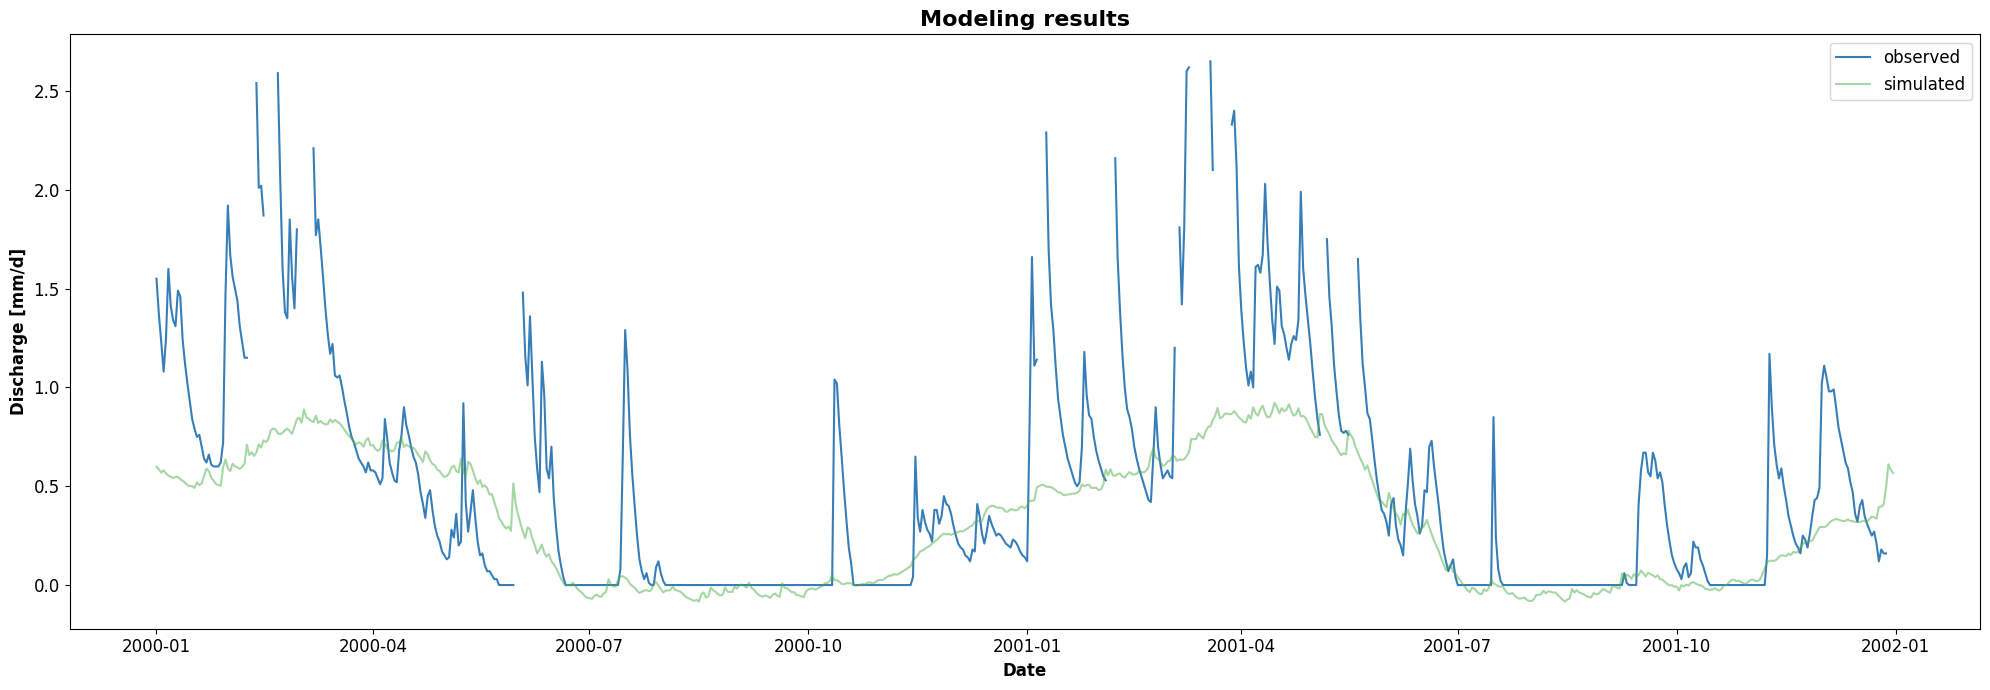

In [11]:
# Plot simulated and observed discharges
basin_to_analyze = random.sample(list(test_results.keys()), 1)[0]

plt.figure(figsize=(20, 7))
plt.plot(test_results[basin_to_analyze]["y_obs"], label="observed", color=color_palette["observed"])
plt.plot(test_results[basin_to_analyze]["y_sim"], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=12, fontweight="bold")
plt.title("Modeling results", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(loc="upper right", fontsize=12)
plt.tight_layout()
plt.show()